In [8]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from transformers import AdamW, AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict, load_dataset, load_metric
import evaluate
import plotly.express as px

current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
sys.path.append(parent_path)

from helpers import ClassifierModel, loadModel, loadTrainTweets, normalizeTweets, tokenizeTweets

c:\Users\andre\Anaconda\envs\myenv_ml2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Tweets

In [3]:
positive_file_path = os.path.join(parent_path,'data/train_pos_full.txt')
negative_file_path = os.path.join(parent_path,'data/train_neg_full.txt')
positive_file_path_small = os.path.join(parent_path,'data/train_pos.txt')
negative_file_path_small = os.path.join(parent_path,'data/train_neg.txt')

# Load  (Full and Small datasets)
df = loadTrainTweets(positive_file_path, negative_file_path)
df_small = loadTrainTweets(positive_file_path_small, negative_file_path_small)

## Model Comparison with Cross-Validation

### TF-IDF Cross-Validation

In [ ]:
# Best Hyperparameters
lambda_best = 0.1
range_best = (1, 2)
max_dfOpt = 0.5
min_dfOpt = 1

text_transformer = TfidfVectorizer(stop_words='english', ngram_range=range_best, 
                                   lowercase=True, max_df=max_dfOpt, min_df=min_dfOpt)

X_train_text = text_transformer.fit_transform(df['tweets'])

logit = LogisticRegression(C=1/lambda_best, solver='lbfgs')#, multi_cl', random_state=17, n_jobs=4)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
kf = KFold(n_splits=5, shuffle=True, random_state=17)


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    cross_val_tfidf = cross_val_score(logit, X_train_text, df['labels'], cv=kf, scoring='accuracy')
    

### BERT base Cross-Validation

In [ ]:
# Normalize Tweets
df_normalized = normalizeTweets(df)

checkpoint = "bert-base-uncased"
dataset = Dataset.from_pandas(df_normalized)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512
def tokenize(batch):
  return tokenizer(batch["tweets"], truncation=True, max_length=512)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
split_indices = list(kf.split(dataset))

cross_val_BERT = []

for fold, (train_idx, eval_idx) in enumerate(split_indices):
    print(f"Training Fold {fold + 1}")
    Acc_max = 0

    # Create train and eval datasets for this fold
    train_dataset = dataset.select(train_idx)
    eval_dataset = dataset.select(eval_idx)

    # Tokenize datasets
    tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
    tokenized_eval_dataset = eval_dataset.map(tokenize, batched=True)

    tokenized_train_dataset.set_format('torch', columns=["input_ids", "labels"])
    tokenized_eval_dataset.set_format('torch', columns=["input_ids", "labels"])

    # Create DataLoader for each fold
    train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
    eval_dataloader = DataLoader(tokenized_eval_dataset, shuffle=False, batch_size=32, collate_fn=data_collator)

    # Create a new model for each fold
    model = ClassifierModel(checkpoint=checkpoint, num_labels=2).to(device)


    optimizer = AdamW(model.parameters(), lr=1e-6)
    num_epochs = 10
    num_training_steps = num_epochs * len(train_dataloader)


    metric = load_metric("accuracy")
    save_weights_every = 5000


    for epoch in range(num_epochs):
        
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):

            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model(**batch)
            pure_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Evaluation Start',flush=True)
        model.eval()
        for batch in eval_dataloader:
            
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=predictions, references=batch['labels'])
        
        accuracy = metric.compute()['accuracy']
        if accuracy>Acc_max:
            Acc_max=accuracy
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Accuracy: {accuracy}",flush=True)

    cross_val_BERT.append(Acc_max)

# Print average accuracy across all folds
print("cross_val_BERT",cross_val_BERT)


### BERTweet Cross-Validation

In [ ]:
# Normalize Tweets
df_normalized = normalizeTweets(df)

checkpoint = "vinai/bertweet-base"
dataset = Dataset.from_pandas(df_normalized)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128
def tokenize(batch):
  return tokenizer(batch["tweets"], truncation=True, max_length=128)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
split_indices = list(kf.split(dataset))

cross_val_BERTweet = []

for fold, (train_idx, eval_idx) in enumerate(split_indices):
    print(f"Training Fold {fold + 1}")
    Acc_max = 0

    # Create train and eval datasets for this fold
    train_dataset = dataset.select(train_idx)
    eval_dataset = dataset.select(eval_idx)

    # Tokenize datasets
    tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
    tokenized_eval_dataset = eval_dataset.map(tokenize, batched=True)

    tokenized_train_dataset.set_format('torch', columns=["input_ids", "labels"])
    tokenized_eval_dataset.set_format('torch', columns=["input_ids", "labels"])

    # Create DataLoader for each fold
    train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
    eval_dataloader = DataLoader(tokenized_eval_dataset, shuffle=False, batch_size=32, collate_fn=data_collator)

    # Create a new model for each fold
    model = ClassifierModel(checkpoint=checkpoint, num_labels=2).to(device)


    optimizer = AdamW(model.parameters(), lr=1e-6)
    num_epochs = 10
    num_training_steps = num_epochs * len(train_dataloader)

    metric = load_metric("accuracy")
    save_weights_every = 5000


    for epoch in range(num_epochs):
        
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):

            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model(**batch)
            pure_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Evaluation Start',flush=True)
        model.eval()
        for batch in eval_dataloader:
            
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=predictions, references=batch['labels'])
        
        accuracy = metric.compute()['accuracy']
        if accuracy>Acc_max:
            Acc_max=accuracy
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Accuracy: {accuracy}",flush=True)

    cross_val_BERTweet.append(Acc_max)

# Print average accuracy across all folds
print("cross_val_BERTweet",cross_val_BERTweet)


### Plotting

After performing the cross-validation on the different methods, which is very time consuming, we save them an plot them below

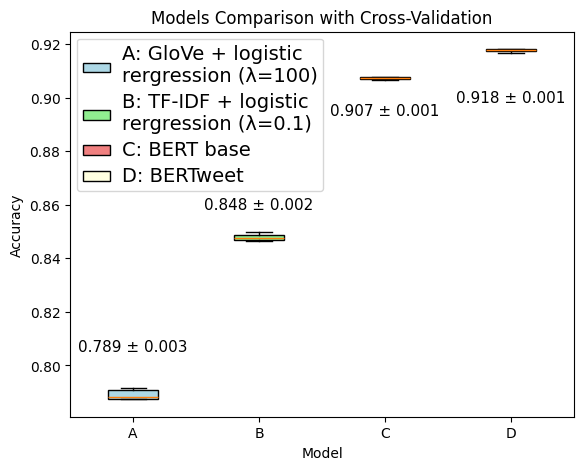

In [9]:
# Create a box plot of the F1 scores
plt.figure(figsize=(6.5, 5))  # Increased the figure width

# Glove
accuracy_1 = np.array([0.7914127347434023, 0.788158729283291, 0.787579626616661, 0.787408306215873, 0.790855440957476])
# accuracy_1 = cross_val_glove


# TF-IDF  
accuracy_2 = np.array([0.84631031, 0.84701631, 0.849776  , 0.84868   , 0.84742   ])
# accuracy_2 = cross_val_tfidf

# BERT
accuracy_3 = np.array([0.9076021993956012,0.9070981982036036,0.9065878723956094,0.90759481756868414,0.9072981982029078])
# accuracy_3 = cross_val_BERT

# BERTweet
accuracy_4 = np.array([0.9177121645756708,0.9180821638356723,0.9165716385147567,0.917471694747534,0.9179871947656482])
# accuracy_4 = cross_val_BERTweet



# Create boxplots for each step
box1 = plt.boxplot(accuracy_1, positions=[1], notch=False, patch_artist=True, widths=0.4, whis=2)  # Set whis to 2
box2 = plt.boxplot(accuracy_2, positions=[2], notch=False, patch_artist=True, widths=0.4, whis=2)
box3 = plt.boxplot(accuracy_3, positions=[3], notch=False, patch_artist=True, widths=0.4, whis=2)
box4 = plt.boxplot(accuracy_4, positions=[4], notch=False, patch_artist=True, widths=0.4, whis=2)

# Set colors for the boxes
# colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

# Set colors for the boxes
# colors = ['mediumseagreen', 'lightcoral', 'cornflowerblue', 'palegoldenrod', 'thistle']

for box, color in zip([box1, box2, box3, box4], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

tit = plt.title('Models Comparison with Cross-Validation')
# tit.set_position((0.1,0))
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Calculate and add the mean values to the box plots
mean_values = [np.mean(accuracy_1), np.mean(accuracy_2), np.mean(accuracy_3), np.mean(accuracy_4)]
std_values = [np.std(accuracy_1), np.std(accuracy_2), np.std(accuracy_3), np.std(accuracy_4)]


for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    if i == 0:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=11)
    elif i == 1:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=11)
    elif i == 2:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=11)
    elif i == 3:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=11)
    elif i == 4:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=11)


# Create a custom legend
legend_boxes = [box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0]]
legend = plt.legend(legend_boxes, ['A: GloVe + logistic \nrergression (λ=100)', 'B: TF-IDF + logistic \nrergression (λ=0.1)', 'C: BERT base', 'D: BERTweet','E: Ensembling with \nBERTweet'])
legend.get_texts()[0].set_fontsize(14)
legend.get_texts()[1].set_fontsize(14)
legend.get_texts()[2].set_fontsize(14)
legend.get_texts()[3].set_fontsize(14)


# Set the x-axis ticks and labels
plt.xticks([1, 2, 3, 4], ['A', 'B', 'C', 'D'])

plt.show()